In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
from itertools import combinations, permutations
from time import time
from numpy.random import random
from scipy.stats import spearmanr, chisquare
import pandas as pd
from fare.metrics import * #_count_inversions,_merge_parity,_merge_eq
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10,5
from sklearn.isotonic import IsotonicRegression
from yang_metrics import *

In [3]:
#check likelihood that rankings meet monotonicity condition
def meets_condition(df):
    # compute whole value counts not proportion for chi2 test
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())
    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)

    # Fit IsotonicRegression
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)
    

    pval = chisquare(y, f_exp=y_)[1]
#     print(y)
#     print(y_)
#     print()
    #small pvalue means we reject he null hypothesis that the samples come from the same distribution
    return pval > 0.01

In [4]:
num_reviewers = 90

pkl_file = open('dfs.pickle', 'rb')#open('../top25_dfs.pickle', 'rb')
dfs = pickle.load(pkl_file)
pkl_file.close()

meets10 = {}
doesnt_meet10 = {}

num_meets = 0

for week in [*dfs.keys()]:

    pkl_file = open('dfs.pickle', 'rb')#open('../top25_dfs.pickle', 'rb')
    dfs = pickle.load(pkl_file)
    pkl_file.close()
    
    dfs10 = {}
    for d_week in [*dfs.keys()]:
        dd = dfs[d_week].drop('Division', axis=1)
        top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
        dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
        dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
    dfs = dfs10

    # Check monotonicity for a single week
    df = dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs[week]['Division']==1.]
    
    if meets_condition(df):
        print(week)
        meets10[week] = week
        num_meets += 1
    else:
        doesnt_meet10[week] = week


1
4
6
7
8
9
10
12
14


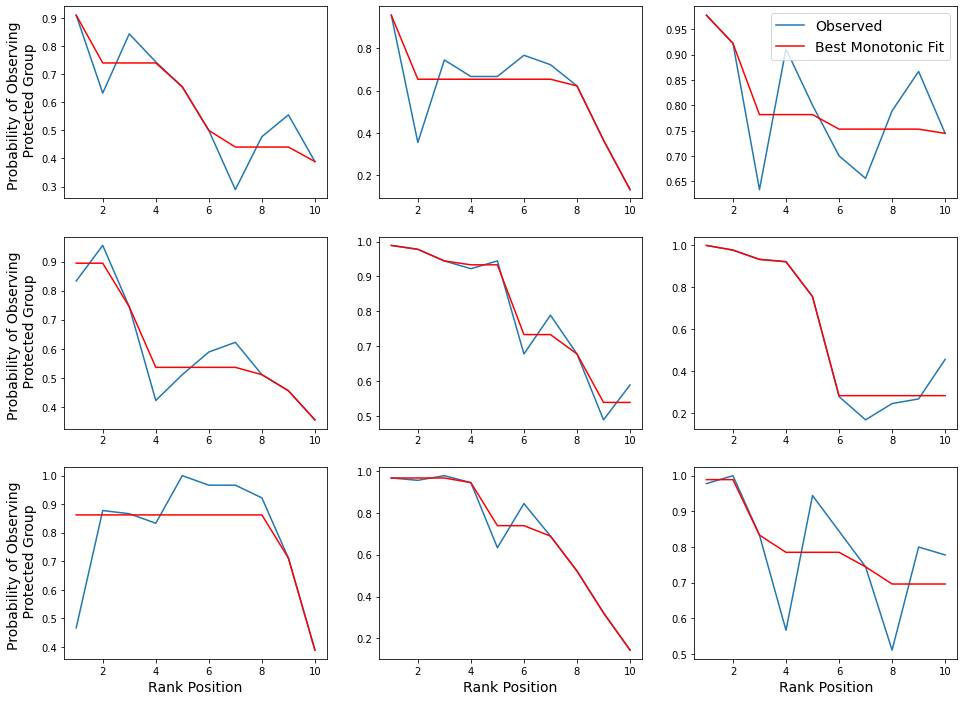

In [5]:
plt.figure(figsize=(16,12)) ## setting over-all figure size (optional)
plt.subplot(4, 4, 1) 

for indx, week in enumerate([*meets10.keys()]):
    
    pkl_file = open('dfs.pickle', 'rb')#open('dfs.pickle', 'rb')
    dfs = pickle.load(pkl_file)
    pkl_file.close()

    dfs10 = {}
    for d_week in [*dfs.keys()]:
        dd = dfs[d_week].drop('Division', axis=1)
        top10 = dd.mean(axis=1).sort_values().rank()[:10].index.values
        dfs10[d_week] = dfs[d_week].drop('Division', axis=1).loc[top10].rank(ascending=True)
        dfs10[d_week]['Division'] = dfs[d_week].loc[top10]['Division']
    dfs = dfs10

    # Check monotonicity for a single week
    df = dfs[week].drop('Division', axis=1).rank(ascending=True)
    df = df[dfs[week]['Division']==1.]
    # r1 = df[df['Division']==0.]['Rank1'].value_counts()
    # r2 = df[df['Division']==0.]['Rank2'].value_counts()
    dfs=[]
    for c in df.columns.values:
        dfs.append(df[c].value_counts())

    counts = pd.concat(dfs, axis=1).fillna(value=0).sum(axis=1)/90
    x = list(range(1,len(counts)+1))
    y = counts.values
    ir = IsotonicRegression(increasing='auto')
    y_ = ir.fit_transform(x, y)
    
    plt.subplot(330 + indx+1)
    
    fig=counts.plot(label='Observed')

    fig.plot(x,y_, c='red', label='Best Monotonic Fit')
    if (indx+1) in [7,8,9]:
        plt.xlabel('Rank Position', size=14)
    
    if (indx+1) in [1,4,7]:
        plt.ylabel('Probability of Observing \n Protected Group', size=14)
        
    if (indx+1) in [3]:
        plt.legend(fontsize=14)
